In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp '/content/drive/MyDrive/util/kaggle.json' ~/.kaggle/

In [ ]:
! kaggle datasets download duttadebadri/image-classification

 99% 2.33G/2.34G [00:23<00:00, 192MB/s]
100% 2.34G/2.34G [00:23<00:00, 105MB/s]


In [ ]:
! unzip image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/images/travel and  adventure/Places365_val_00009663.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009664.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009665.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009666.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009667.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009668.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009669.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009670.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009671.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009672.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009673.jpg  
  inflating: images/images/travel and  adventure/Places365_val_00009674.jpg  
  inflating: 

<h1 style="background-color:#297a38;color:white;font-size:35px;font-family:verdana"><center>Rotten or Fresh Fruit Classification </center><h1>

In [ ]:
import sys
import os
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k
import keras

In [ ]:
transformation_ratio = 0.20

datagen = ImageDataGenerator(rescale=1. / 255,
                             validation_split = 0.2,
                             rotation_range=transformation_ratio,
                             shear_range=transformation_ratio,
                             zoom_range=transformation_ratio,
                             cval=transformation_ratio,
                             horizontal_flip=True,
                             vertical_flip=False)

In [ ]:
# load and iterate training dataset
train_it = datagen.flow_from_directory("/content/images/images", 
                                       target_size=(224,224), 
                                       color_mode='rgb', 
                                       class_mode="categorical",
                                       batch_size=12,
                                       subset = "training")


# Validation Data
val_it = datagen.flow_from_directory('/content/images/images',
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=12,
                                     subset='validation')


# load and iterate test dataset
test_it = datagen.flow_from_directory("/content/validation/validation", 
                                      target_size=(224,224), 
                                      color_mode='rgb', 
                                      class_mode="categorical")

Found 28075 images belonging to 4 classes.
Found 7018 images belonging to 4 classes.
Found 122 images belonging to 4 classes.


<h1 style="background-color:#339946;color:white;font-size:24px;font-family:verdana">Load ImageNet Base Model<h1>

In [ ]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<h2 style="background-color:#339946;color:white;font-size:24px;font-family:verdana">Freeze Base Model<h2>

In [ ]:
# Freeze base model
base_model.trainable = False

<h2 style="background-color:#339946;color:white;font-size:24px;font-family:verdana">Add Layers to Model<h2>

In [ ]:
from keras.models import Model
from keras.layers import *

# Create inputs with correct shape
inputs = Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = Flatten()(x)

# Add a hidden layer
x = Dense(256, activation='relu')(x)

# Add a dropout layer
x = Dropout(.5)(x)

# Add final dense layer
outputs = Dense(4, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,138,500
Trainable params: 6,423,812
Non-tr

<h2 style="background-color:#339946;color:white;font-size:24px;font-family:verdana">Compile Model<h2>

In [ ]:
model.compile(loss='categorical_crossentropy',
              metrics=["accuracy"],
             optimizer = 'nadam')

<h2 style="background-color:#339946;color:white;font-size:24px;font-family:verdana">Train the Model<h2>

In [ ]:
history = model.fit_generator(generator = train_it,
                              steps_per_epoch=train_it.samples/train_it.batch_size,
                              epochs=16,
                              validation_data=val_it,
                              validation_steps=test_it.samples/test_it.batch_size,
)

<ipython-input-35-d45733edde81>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_it,


Epoch 1/16
1368/2339 [================>.............] - ETA: 3:17 - loss: 0.6443 - accuracy: 0.7569

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


2339/2339 [==============================] - 478s 204ms/step - loss: 0.6193 - accuracy: 0.7674 - val_loss: 0.5251 - val_accuracy: 0.8125
Epoch 2/16
2339/2339 [==============================] - 468s 200ms/step - loss: 0.5238 - accuracy: 0.8048 - val_loss: 0.3856 - val_accuracy: 0.8750
Epoch 3/16
2339/2339 [==============================] - 463s 198ms/step - loss: 0.4804 - accuracy: 0.8266 - val_loss: 0.5296 - val_accuracy: 0.8542
Epoch 4/16
2339/2339 [==============================] - 463s 198ms/step - loss: 0.4567 - accuracy: 0.8327 - val_loss: 0.5849 - val_accuracy: 0.8333
Epoch 5/16
2339/2339 [==============================] - 472s 202ms/step - loss: 0.4378 - accuracy: 0.8419 - val_loss: 0.6058 - val_accuracy: 0.8125
Epoch 6/16
2339/2339 [==============================] - 485s 207ms/step - loss: 0.4255 - accuracy: 0.8458 - val_loss: 1.3930 - val_accuracy: 0.6667
Epoch 7/16
2339/2339 [==============================] - 468s 200ms/step - loss: 0.4066 - accuracy: 0.8553 - val_loss: 0.246

<h2 style="background-color:#339946;color:white;font-size:24px;font-family:verdana">Evaluate the Model<h2>

In [ ]:
import matplotlib.pyplot as plt

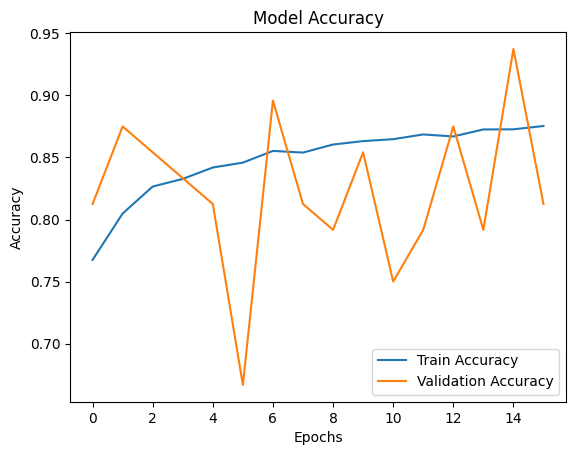

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'], loc = 'lower right')

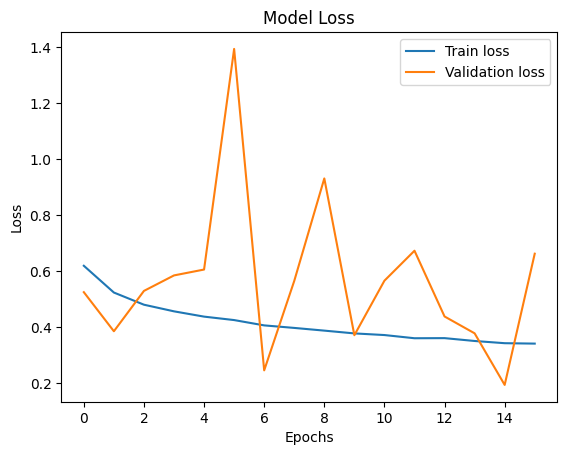

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train loss','Validation loss'], loc = 'upper right')

In [ ]:
model.evaluate(test_it, steps=test_it.samples/test_it.batch_size)

3/3 [==============================] - 11s 2s/step - loss: 0.3629 - accuracy: 0.8934


[0.36285489797592163, 0.8934426307678223]

In [ ]:
# Save weight and model format
model.save('/content/drive/MyDrive/util/image_classifier.h5')

In [ ]:
transformation_ratio = 0.15

datagen2 = ImageDataGenerator(rescale=1. / 255,
                             validation_split = 0.3,
                             rotation_range=transformation_ratio,
                             shear_range=transformation_ratio,
                             zoom_range=transformation_ratio,
                             cval=transformation_ratio,
                             horizontal_flip=True,
                             vertical_flip=False)

In [ ]:
# load and iterate training dataset
train_it2 = datagen2.flow_from_directory("/content/images/images", 
                                       target_size=(224,224), 
                                       color_mode='rgb', 
                                       class_mode="categorical",
                                       batch_size=12,
                                       subset = "training")


# Validation Data
val_it2 = datagen2.flow_from_directory('/content/images/images',
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=12,
                                     subset='validation')


# load and iterate test dataset
test_it2 = datagen2.flow_from_directory("/content/validation/validation", 
                                      target_size=(224,224), 
                                      color_mode='rgb', 
                                      class_mode="categorical")

Found 24566 images belonging to 4 classes.
Found 10527 images belonging to 4 classes.
Found 122 images belonging to 4 classes.


In [ ]:
# Create inputs with correct shape
inputs = Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = Flatten()(x)

# Add a hidden layer
x = Dense(256, activation='relu')(x)

# Add a dropout layer
x = Dropout(.1)(x)

# Add final dense layer
outputs = Dense(4, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model2 = Model(inputs, outputs)

In [ ]:
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,138,500
Trainable params: 6,423,812
Non-tr

In [ ]:
model2.compile(loss='categorical_crossentropy',
              metrics=["accuracy"],
             optimizer = 'nadam')

<h2 style="background-color:#339946;color:white;font-size:24px;font-family:verdana">Train the Model<h2>

In [ ]:
history = model2.fit_generator(generator = train_it2,
                              steps_per_epoch=train_it2.samples/train_it2.batch_size,
                              epochs=16,
                              validation_data=val_it2,
                              validation_steps=test_it2.samples/test_it2.batch_size,
)

<ipython-input-47-5bb74973665b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(generator = train_it2,


Epoch 1/16
 734/2047 [=========>....................] - ETA: 4:39 - loss: 0.5896 - accuracy: 0.7988

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1373/2047 [===================>..........] - ETA: 2:19 - loss: 0.5258 - accuracy: 0.8148

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


2047/2047 [==============================] - 421s 205ms/step - loss: 0.4781 - accuracy: 0.8305 - val_loss: 0.5145 - val_accuracy: 0.8333
Epoch 2/16
2047/2047 [==============================] - 409s 200ms/step - loss: 0.3493 - accuracy: 0.8736 - val_loss: 0.3267 - val_accuracy: 0.8958
Epoch 3/16
2047/2047 [==============================] - 410s 200ms/step - loss: 0.2998 - accuracy: 0.8916 - val_loss: 0.6557 - val_accuracy: 0.8125
Epoch 4/16
2047/2047 [==============================] - 406s 198ms/step - loss: 0.2764 - accuracy: 0.8988 - val_loss: 0.6581 - val_accuracy: 0.8333
Epoch 5/16
2047/2047 [==============================] - 412s 201ms/step - loss: 0.2481 - accuracy: 0.9098 - val_loss: 0.5570 - val_accuracy: 0.7500
Epoch 6/16
2047/2047 [==============================] - 416s 203ms/step - loss: 0.2346 - accuracy: 0.9148 - val_loss: 0.3072 - val_accuracy: 0.8542
Epoch 7/16
2047/2047 [==============================] - 412s 201ms/step - loss: 0.2131 - accuracy: 0.9212 - val_loss: 0.438

<h2 style="background-color:#339946;color:white;font-size:24px;font-family:verdana">Evaluate the Model<h2>

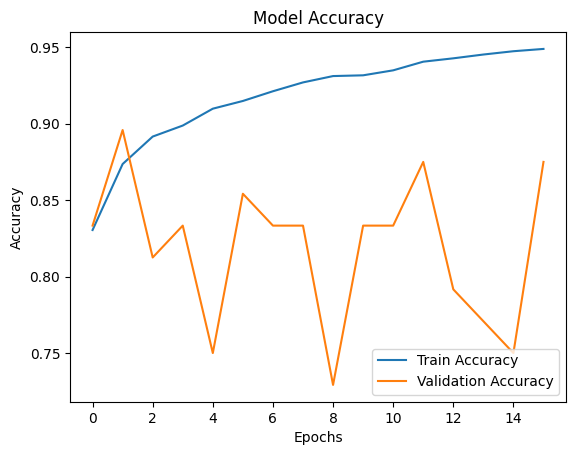

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'], loc = 'lower right')

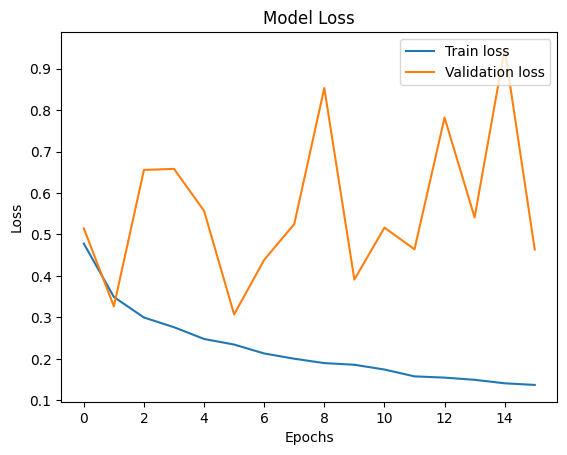

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train loss','Validation loss'], loc = 'upper right')

In [ ]:
model2.evaluate(test_it2, steps=test_it2.samples/test_it2.batch_size)

3/3 [==============================] - 2s 655ms/step - loss: 0.6807 - accuracy: 0.8525


[0.6806625127792358, 0.8524590134620667]

In [ ]:
# Save weight and model format
model2.save('/content/drive/MyDrive/util/image_classifier2.h5')